In [2]:
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# import scraped search data to dataframe
search = pd.read_csv('Data/bozeman_search_housing.csv', delimiter=',')

In [4]:
# create df of listing urls into csv
urls = search['detailUrl']
urls.to_csv('data/bozeman_housing_urls.csv', index=False)

In [5]:
# import scraped listing data (from individual URL) to dataframe
df = pd.read_csv('Data/bozeman_housing_info.csv', delimiter=',', low_memory=False)

In [6]:
# view columns of listing data
df.info()
print(df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Columns: 2000 entries, abbreviatedAddress to zpid
dtypes: bool(108), float64(757), int64(43), object(1092)
memory usage: 10.7+ MB
['abbreviatedAddress', 'adTargets/aamgnrc1', 'adTargets/bd', 'adTargets/city', 'adTargets/cnty', 'adTargets/dma', 'adTargets/fsbid', 'adTargets/guid', 'adTargets/listtp', 'adTargets/lot', 'adTargets/mlat', 'adTargets/mlong', 'adTargets/pid', 'adTargets/prange', 'adTargets/premieragent', 'adTargets/price', 'adTargets/proptp', 'adTargets/sqft', 'adTargets/sqftrange', 'adTargets/ssid', 'adTargets/state', 'adTargets/tflag', 'adTargets/yrblt', 'adTargets/zip', 'adTargets/zusr', 'address/city', 'address/community', 'address/neighborhood', 'address/state', 'address/streetAddress', 'address/subdivision', 'address/zipcode', 'apartmentsForRentInZipcodeSearchUrl/path', 'attributionInfo/agentEmail', 'attributionInfo/agentLicenseNumber', 'attributionInfo/agentName', 'attributionInfo/agentPhoneNumber'

In [7]:
# create important feature keyword list
relevant_keywords = [
    'streetAddress', 'city', 'state', 'zipcode', 'neighborhood',
    'latitude', 'longitude',
    'price', 'currency',
    'bedrooms', 'bathrooms', 'livingArea', 'lotSize', 'garage', 'cooling', 'heating', 'hasPrivatePool', 'water', 'levels', 'stories',
    'yearBuilt',
    'homeType', 'propertyTypeDimension',
    'homeStatus', 'listingTypeDimension',
    'is_FSBO', 'is_newHome', 'is_foreclosure', 'is_FSBA',
    'isPremierBuilder', 'isShowcaseListing'
]

# Match columns that end with or contain one of the keywords
relevant_columns = [col for col in df.columns if any(kw in col for kw in relevant_keywords)]

# Extract just these columns
df_model = df[relevant_columns].copy()

# Flatten column names by taking just the last part (after the last '/')
df_model.columns = [col.split('/')[-1] for col in df_model.columns]

# Drop exact duplicates (e.g., multiple "price" columns from different propertyDetails indices)
df_model = df_model.loc[:, ~df_model.columns.duplicated()]

# Drop rows with missing target values (price)
df_model = df_model.dropna(subset=['price'])


In [8]:
# view filtered data set from keywords
print(df_model.head())
print(df_model.columns.tolist())

      city    price state  neighborhood        streetAddress  zipcode  \
0  Bozeman  1250000    MT           NaN  8373 Goldenstein Ln    59715   
1  Bozeman  1389000    MT           NaN    1440 Ryun Sun Way    59718   
2  Bozeman  1925000    MT           NaN   4054 Rain Roper Dr    59715   
3  Bozeman   559000    MT           NaN   2603 Snapdragon St    59718   
4  Bozeman  3850000    MT           NaN        3640 Jagar Ln    59718   

   bathrooms  bedrooms  cityId          path  ... openParkingCapacity  \
0        4.0       5.0   44281  /bozeman-mt/  ...                 NaN   
1        3.0       5.0   44281  /bozeman-mt/  ...                 NaN   
2        4.0       3.0   44281  /bozeman-mt/  ...                 NaN   
3        2.0       4.0   44281  /bozeman-mt/  ...                 NaN   
4        3.0       4.0   44281  /bozeman-mt/  ...                 NaN   

  parkingCapacity stories storiesTotal waterBodyName waterView  waterViewYN  \
0               2     2.0          NaN     

In [9]:
# select important columns into final data set
df_model = df_model[['levels','price','latitude','longitude', 'bedrooms', 'bathrooms', 'homeType','livingArea','lotSize','hasPrivatePool','garageParkingCapacity','yearBuilt','is_FSBA', 'is_FSBO', 'is_foreclosure', 'is_newHome']]
print(df_model.head(100))

         levels    price   latitude   longitude  bedrooms  bathrooms  \
0           Two  1250000  45.639770 -111.035430       5.0        4.0   
1           Two  1389000  45.697390 -111.096900       5.0        3.0   
2           Two  1925000  45.678207 -111.005130       3.0        4.0   
3           Two   559000  45.676370 -111.086020       4.0        2.0   
4           Two  3850000  45.667190 -111.205666       4.0        3.0   
..          ...      ...        ...         ...       ...        ...   
95          Two  1450000  45.713547 -111.196950       3.0        3.0   
96          Two   629000  45.676370 -111.086020       3.0        3.0   
97  Multi/Split   834000  45.651897 -111.040710       4.0        3.0   
98          NaN    49995        NaN         NaN       2.0        1.0   
99          One   885000  45.681232 -111.027000       3.0        2.0   

         homeType  livingArea   lotSize  hasPrivatePool  \
0   SINGLE_FAMILY      3149.0   16531.0             NaN   
1   SINGLE_FAMILY

In [10]:
# Clean Levels

print(df_model['levels'].unique())
print(df_model['homeType'].unique())

df_model['levels_clean'] = (
    df_model['levels'].astype(str).str.strip().str.lower().replace({
        '1.0': 'One', 'one': 'One', 'One': 'One',
        '2.0': 'Two', 'two': 'Two', 'Two': 'Two',
        'three or more': 'Three Or More',
        'multi/split': 'Split'
    })
)

df_model['levels_clean'] = df_model['levels_clean'].where(
    df_model['levels_clean'].isin(['One', 'Two', 'Three Or More', 'Split']),
    'Unknown'
)

levels_dummies = pd.get_dummies(df_model['levels_clean'], prefix='level')

df_model = pd.concat([df_model.drop(columns=['levels']), levels_dummies], axis=1)

df_model = df_model.drop(columns = 'levels_clean')

# view filtered data set from keywords
print(df_model.head(100))
print(df_model.columns.tolist())

['Two' nan 'One' 'Multi/Split' 'Three Or More' 'Other' '2.0' '1.0']
['SINGLE_FAMILY' 'MANUFACTURED' 'CONDO' 'LOT' 'TOWNHOUSE' nan
 'MULTI_FAMILY']
      price   latitude   longitude  bedrooms  bathrooms       homeType  \
0   1250000  45.639770 -111.035430       5.0        4.0  SINGLE_FAMILY   
1   1389000  45.697390 -111.096900       5.0        3.0  SINGLE_FAMILY   
2   1925000  45.678207 -111.005130       3.0        4.0  SINGLE_FAMILY   
3    559000  45.676370 -111.086020       4.0        2.0  SINGLE_FAMILY   
4   3850000  45.667190 -111.205666       4.0        3.0  SINGLE_FAMILY   
..      ...        ...         ...       ...        ...            ...   
95  1450000  45.713547 -111.196950       3.0        3.0  SINGLE_FAMILY   
96   629000  45.676370 -111.086020       3.0        3.0  SINGLE_FAMILY   
97   834000  45.651897 -111.040710       4.0        3.0  SINGLE_FAMILY   
98    49995        NaN         NaN       2.0        1.0            NaN   
99   885000  45.681232 -111.027000     

In [11]:
df_model['homeType'] = df_model['homeType'].where(
    df_model['homeType'].isin(['SINGLE_FAMILY', 'MANUFACTURED', 'CONDO', 'LOT','TOWNHOUSE','MULTI_FAMILY']),
    'Unknown'
)

type_dummies = pd.get_dummies(df_model['homeType'], prefix='homeType')

df_model = pd.concat([df_model.drop(columns=['homeType']), type_dummies], axis=1)
        
cols = ['is_FSBA', 'is_FSBO', 'is_foreclosure', 'is_newHome']

for col in cols:
    df_model[col] = (
        df_model[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .map({'true': 1, 'false': 0})
        .fillna(0)
        .astype(int)
    )

for col in df_model.columns:
    if df_model[col].dtype == 'bool' or df_model[col].dtype == 'boolean':
        df_model[col] = df_model[col].astype(int)

print(df_model.head(100))
print(df_model.columns.tolist())

      price   latitude   longitude  bedrooms  bathrooms  livingArea   lotSize  \
0   1250000  45.639770 -111.035430       5.0        4.0      3149.0   16531.0   
1   1389000  45.697390 -111.096900       5.0        3.0      3294.0    9931.0   
2   1925000  45.678207 -111.005130       3.0        4.0      3344.0  553647.0   
3    559000  45.676370 -111.086020       4.0        2.0      1565.0    6708.0   
4   3850000  45.667190 -111.205666       4.0        3.0      3456.0  194626.0   
..      ...        ...         ...       ...        ...         ...       ...   
95  1450000  45.713547 -111.196950       3.0        3.0      3664.0  130680.0   
96   629000  45.676370 -111.086020       3.0        3.0      1565.0    6708.0   
97   834000  45.651897 -111.040710       4.0        3.0      3357.0   12980.0   
98    49995        NaN         NaN       2.0        1.0         NaN       NaN   
99   885000  45.681232 -111.027000       3.0        2.0      1649.0    8398.0   

    hasPrivatePool  garageP

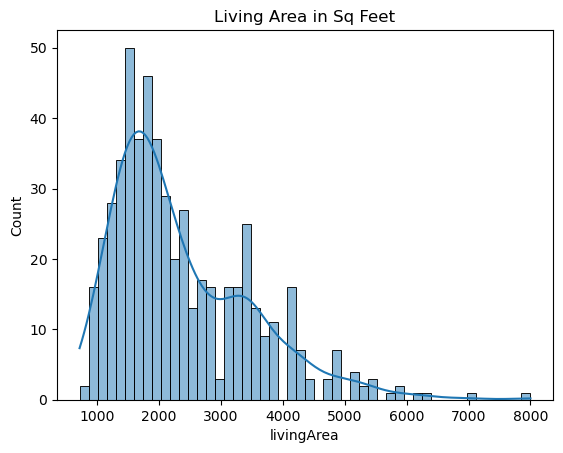

In [13]:
# Exploratory Data Analysis

# Home area distribution
plot = sns.histplot(x = df_model['livingArea'],  kde = True, bins = 50)
plot.set_title('Living Area in Sq Feet')
plt.show()


Looking at the distribution of living area of houses for sale in Bozeman, MT, most of the houses have a living area between 1000 and 3000 square feet. This means that Bozeman has similar sized houses to the national average of 2300-2500 square feet. There are very few houses with living area greater than 5000 square feet. 

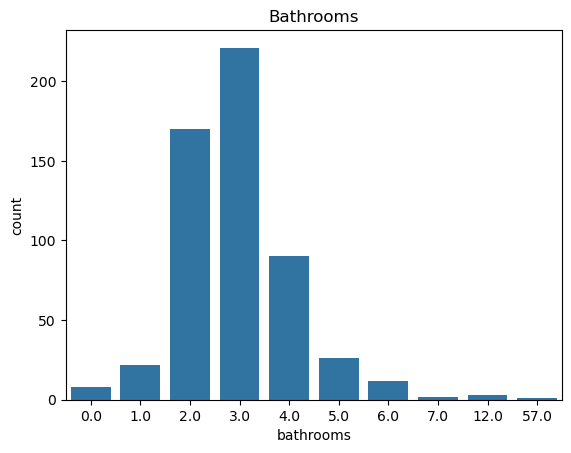

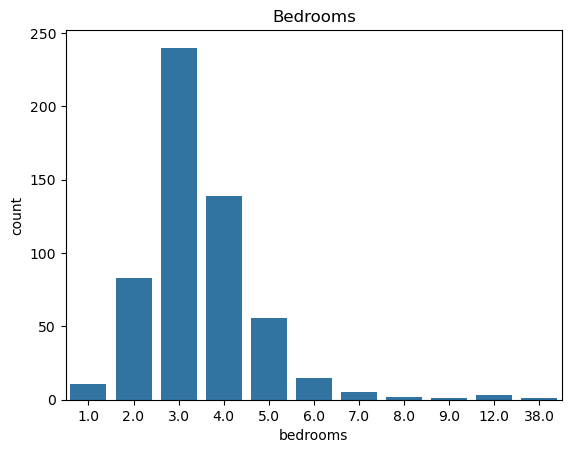

In [15]:
# Bathroom and Bedroom distribution
bath = sns.countplot(x = 'bathrooms', data = df_model)
bath.set_title('Bathrooms')
plt.show()

bed = sns.countplot(x = 'bedrooms', data = df_model)
bed.set_title('Bedrooms')
plt.show()


From these two graphs, we get a good idea about the average house design of houses on the market in Bozeman, MT. Majority of the houses have 3 bedrooms and either 2 or 3 bathrooms. These distributions along with the living area distributions can put together a picture of a common house for sale in Bozeman.

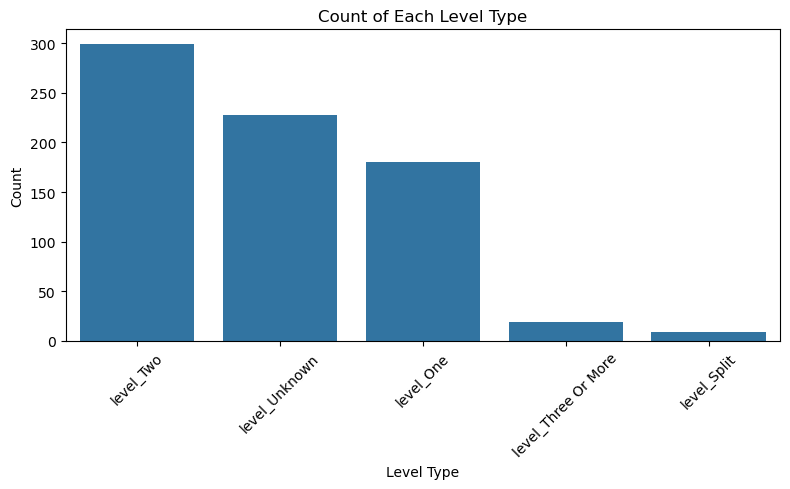

Number of homes with unknown level: 228


In [17]:
# Level distribution
level_cols = [col for col in df_model.columns if col.startswith("level_")]

# Count number of True values for each level column
level_counts = df_model[level_cols].sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=level_counts.index, y=level_counts.values)
plt.xticks(rotation=45)
plt.title("Count of Each Level Type")
plt.ylabel("Count")
plt.xlabel("Level Type")
plt.tight_layout()
plt.show()

unknown_count = df_model["level_Unknown"].sum()
print(f"Number of homes with unknown level: {unknown_count}")

Two level homes are the most common in Bozeman. After that, the most common homes have an unknown amount of levels, or one level. Very few homes have three or more levels, or are split level. This can be related to the living area distribution, as many one or two level homes will be in the 1500-3000 square foot range. 

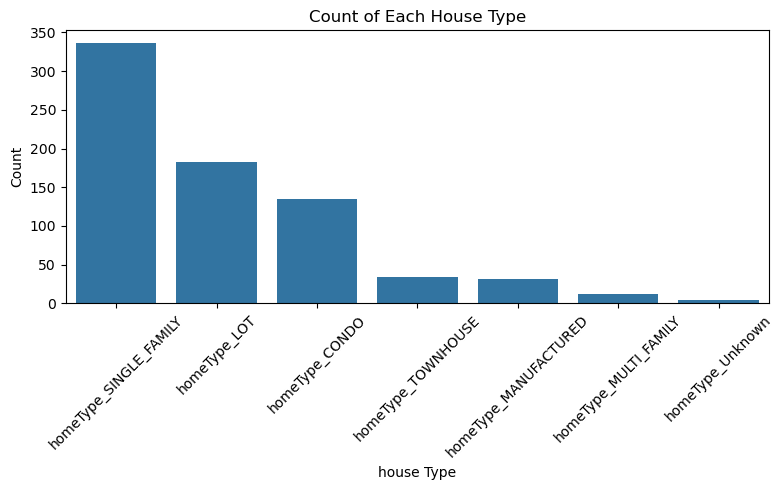

In [19]:
# House type distribution
type_cols = [col for col in df_model.columns if col.startswith("homeType_")]

# Count number of True values for each level column
type_counts = df_model[type_cols].sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.xticks(rotation=45)
plt.title("Count of Each House Type")
plt.ylabel("Count")
plt.xlabel("house Type")
plt.tight_layout()
plt.show()


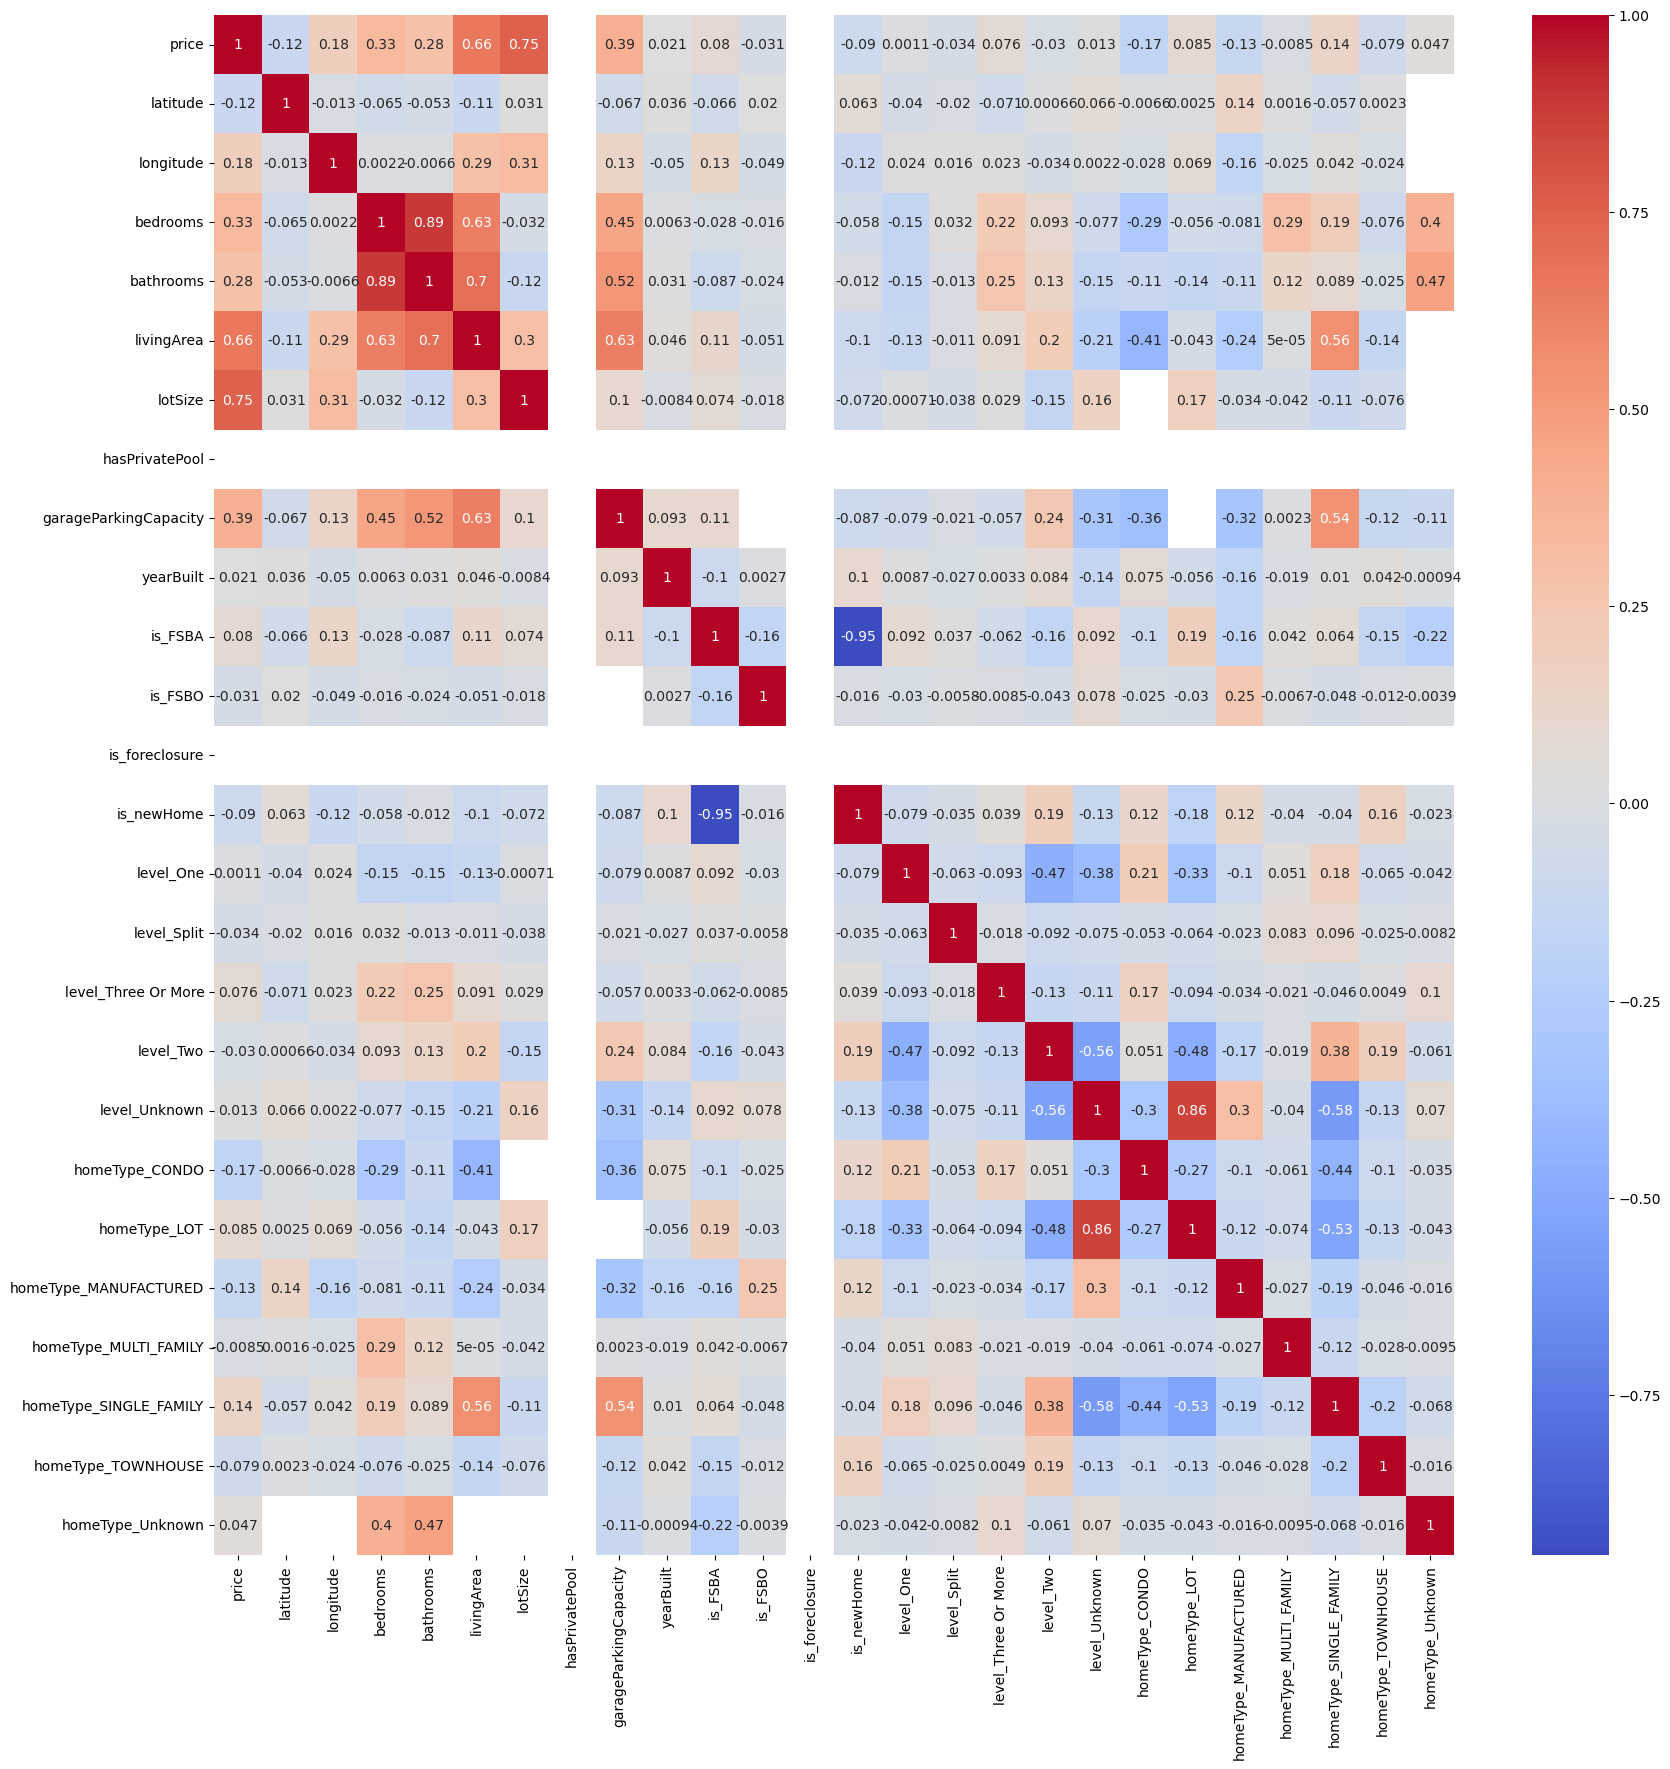

In [20]:


plt.figure(figsize=(20, 20))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm')
plt.show()


In this correlation matrix heatmap, we see the price of the house has high positive correlation with lot size and living area. We also see that living area has a high positive correlation with bedrooms and bathrooms. This helps indicate our previous obersevations about their relation.

In [22]:
# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('price',axis=1), df_model['price'], test_size=0.2, random_state=42)

## Decision Tree Regressor

In [24]:
# Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

#creating Decision Tree Regressor object
dtr = DecisionTreeRegressor()

In [25]:
# Hypertune parameters

from sklearn.model_selection import GridSearchCV

# Defining parameters
parameters  = {'max_depth':[2,4,6,8],
               'min_samples_split':[2,4,6,8],
               'min_samples_leaf':[1,2,3,4],
               'max_features':['auto','sqrt','log2'],
               'random_state':[0,42]}

# Creating GridSearchCV object
grid_search = GridSearchCV(dtr, parameters, cv=5, scoring='neg_mean_squared_error')

# Fitting data to grid search object
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
# Best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}


C:\Users\ibarr\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
640 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ibarr\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ibarr\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\ibarr\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ibarr\anaconda3\Lib\site-packa

In [26]:
decisionTree = DecisionTreeRegressor(**best_params)
decisionTree

DecisionTreeRegressor(max_depth=8, max_features='log2', min_samples_split=4,
                      random_state=42)

In [27]:
# Training the model
decisionTree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, max_features='log2', min_samples_split=4,
                      random_state=42)

In [28]:
# Training Accuracy
decisionTree.score(X_train, y_train)

0.7272980589420475

In [29]:
# Predicting the house price
d_pred = decisionTree.predict(X_test)

dft = pd.DataFrame({'Actual': y_test, 'Predicted': d_pred})
dft.reset_index(drop=True, inplace=True)
dft.head(10)

,Actual,Predicted
0,715000,1.146775e+06
1,415000,7.474276e+05
2,899000,7.474276e+05
3,669500,7.474276e+05
4,2250000,2.306582e+06
5,609900,7.474276e+05
6,2099000,2.306582e+06
7,1249000,1.146775e+06
8,379000,1.401946e+06
9,730000,7.474276e+05


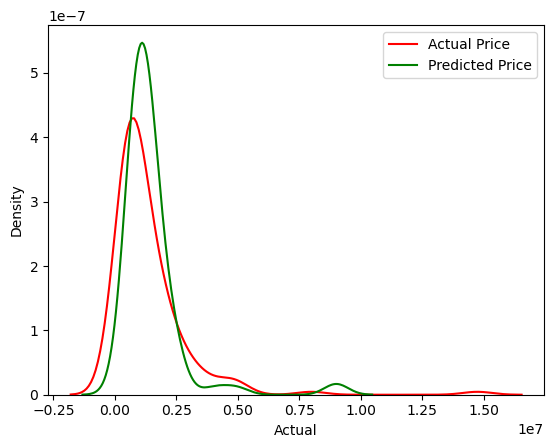

In [30]:
# Plot Actual vs. Predicted
sns.kdeplot(data=dft['Actual'], color='r', label='Actual Price')
sns.kdeplot(data=dft['Predicted'], color='g', label='Predicted Price')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print("R2 Score: ", r2_score(y_test, d_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, d_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test, d_pred))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, d_pred)))

R2 Score:  -0.0851267074128681
Mean Squared Error:  2847781964429.7773
Mean Absolute Error:  810536.6817942879
Root Mean Squared Error:  1687537.2483088418


## Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor Object
randomForest = RandomForestRegressor()
randomForest

RandomForestRegressor()

In [34]:
# Training the model
randomForest.fit(X_train, y_train)

RandomForestRegressor()

In [35]:
# Training Accuracy
randomForest.score(X_train, y_train)

0.9573206594506782

In [36]:
# Predicting the house price
r_pred = randomForest.predict(X_test)

dfr = pd.DataFrame({'Actual': y_test, 'Predicted': r_pred})
dfr.reset_index(drop=True, inplace=True)
dfr.head(10)

,Actual,Predicted
0,715000,7.280770e+05
1,415000,4.715678e+05
2,899000,8.253480e+05
3,669500,6.493332e+05
4,2250000,1.969148e+06
5,609900,5.823825e+05
6,2099000,2.093805e+06
7,1249000,1.346706e+06
8,379000,6.046644e+05
9,730000,9.202300e+05


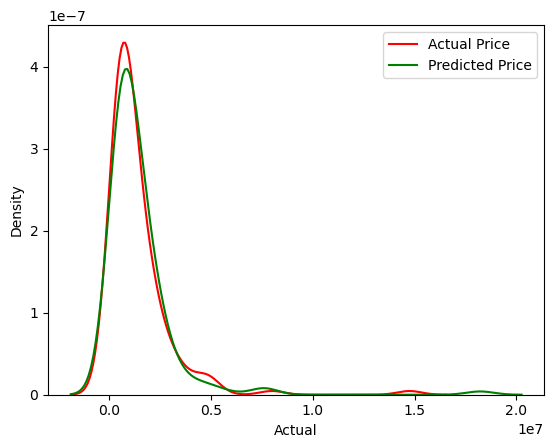

In [37]:
# Plot Actual vs. Predicted
sns.kdeplot(data=dfr['Actual'], color='r', label='Actual Price')
sns.kdeplot(data=dfr['Predicted'], color='g', label='Predicted Price')
plt.legend()
plt.show()

In [38]:
print("R2 Score: ", r2_score(y_test, r_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, r_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test, r_pred))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, r_pred)))

R2 Score:  0.7838213084753792
Mean Squared Error:  567334463903.8628
Mean Absolute Error:  353585.73825953074
Root Mean Squared Error:  753216.0804867769


## XGBoost Regression

In [40]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [41]:
# Parameter Tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 5, 10],
}

xgb = XGBRegressor(random_state=42, enable_categorical=True)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,                  # Number of random combinations to try
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best model
print("Best parameters found:", random_search.best_params_)
print("Best R2 score on training:", random_search.best_score_)

best_xgb = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.8}
Best R2 score on training: 0.7505359053611755


In [42]:
print(best_xgb.score(X_train, y_train))

0.9907103180885315


In [43]:
# Predict on the test set
xg_pred = best_xgb.predict(X_test)

# Create DataFrame for Actual vs Predicted
xgb = pd.DataFrame({'Actual': y_test, 'Predicted': xg_pred})
xgb.reset_index(drop=True, inplace=True)
xgb.head(10)

,Actual,Predicted
0,715000,7.610842e+05
1,415000,4.554145e+05
2,899000,8.173371e+05
3,669500,6.753138e+05
4,2250000,2.608545e+06
5,609900,5.666052e+05
6,2099000,2.581210e+06
7,1249000,1.450611e+06
8,379000,5.168222e+05
9,730000,7.990036e+05


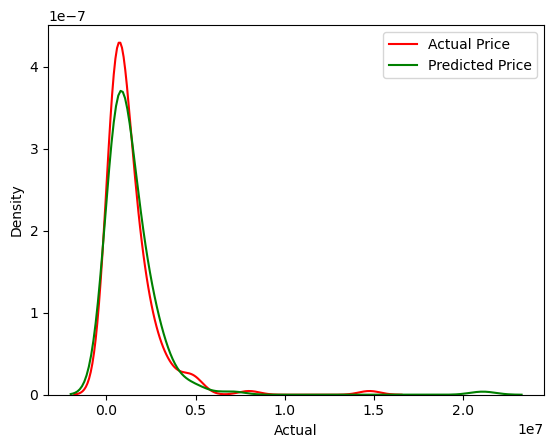

In [44]:
sns.kdeplot(data=xgb['Actual'], color='r', label='Actual Price')
sns.kdeplot(data=xgb['Predicted'], color='g', label='Predicted Price')
plt.legend()
plt.show()

In [45]:
print("R2 Score: ", r2_score(y_test, xg_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, xg_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test, xg_pred))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, xg_pred)))

R2 Score:  0.6679741144180298
Mean Squared Error:  871361181144.6448
Mean Absolute Error:  393023.0811011905
Root Mean Squared Error:  933467.2898096883


## Conclusion

From our exploratory data analysis, we can conclude that lot size and living area have the greatest effect on house prices in Bozeman, MT. We were also able to picture a common house for sale in Bozeman, as most houses had 3 bedrooms, 2-3 bathrooms, and were 1-2 stories tall.

When comparing the regression models, decision tree, random forest, and xgboost, to one another, we see that the best model is random forest, followed by xgboost, with decision tree last. While xgboost had the highest accuracy, the random forest model had an R^2 value of .814, while xgboost has an R^2 of 0.753. The decision tree model had the worst R^2 value and accuracy score. 